# Test Model 0

\begin{center}
    % Do a TixZ diagram of a 2 states model
    \begin{tikzpicture}[node distance=2cm, auto]
        \node (1) [rectangle, draw, minimum size=1.5cm] {1};
        \node (2) [rectangle, draw, minimum size=1.5cm, right of=1, xshift=1cm] {2};

        % Arrows
        \draw[->] ++(0.75,-0.25) -- node[midway, below] {$\lambda_{12}$} ++(1.5, 0);
        \draw[->] (2.south) -- node[midway, left] {$\delta_2$} ++(0,-1);
        \draw[->] (1.south) -- node[midway, left] {$\delta_1$} ++(0,-1);
        \draw[->] ++(2.25,0.25) -- node[midway, above] {$\lambda_{21}$} ++(-1.5, 0) ;
    \end{tikzpicture}
\end{center}

2 state model, with 2 giving birth to n 1, and 1 transitioning to 2

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

In [24]:
death1 = 0.0004
comp = 0.0001
death2 = 0.008
lambda12 = 0.005
lambda21 = 0.025
n = 20

Xinit = [2700, 1500]
X1 = [Xinit[0]]
X2 = [Xinit[1]]

## First case : only coeff and deterministic convergence

### Birth death process

In [25]:
# Define the birth-death process
def bd(X1, X2, death1, comp, death2, lambda12, lambda21, n, Tmax):
    t = [0]
    x1 = X1[-1]
    x2 = X2[-1]
    while t[-1] < Tmax :
        if x1 == 0 and x2 == 0:
            print("only death remains")
            break
        tot_rate = (death1 + lambda12 + comp*x1)*x1 + (death2 + lambda21)*x2
        t.append( t[-1] + np.random.exponential(1 / tot_rate))
        p = np.random.rand()
        if p < ((death1 + comp*x1)*x1) / tot_rate:
            x1 -= 1  # Death of 1
        elif p < ((death1 + comp*x1 + lambda12)*x1) / tot_rate:
            x1 -= 1 # Transi to 2
            x2 += 1
        elif p < ((death1 + comp*x1 + lambda12)*x1 + death2*x2 ) / tot_rate:
            x2 -= 1 # Death of 2
        else : 
            x1 += n # Birth of 1
        X1.append(x1)
        X2.append(x2)
    return t, X1, X2

In [26]:
# Run the simulation
Tmax = 1000
t, X1, X2 = bd(X1, X2, death1, comp, death2, lambda12, lambda21, n, Tmax)

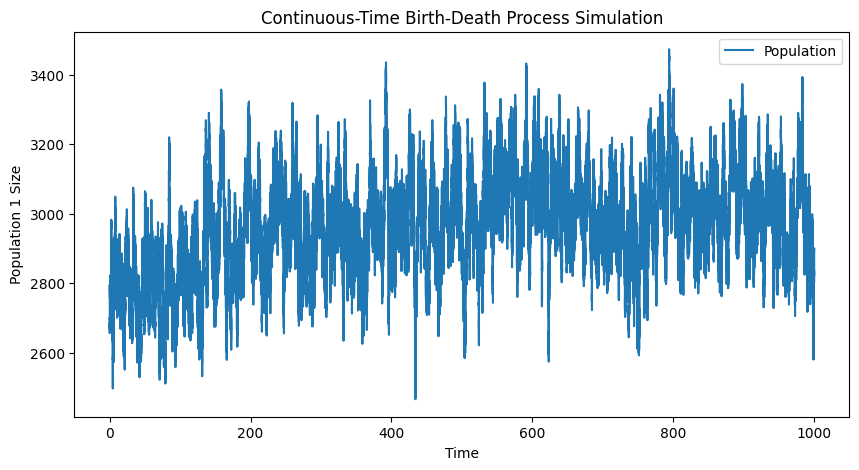

In [27]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.step(t, X1, where="post", label='Population')
plt.xlabel('Time')
plt.ylabel('Population 1 Size')
plt.title('Continuous-Time Birth-Death Process Simulation')
plt.legend()
plt.show()

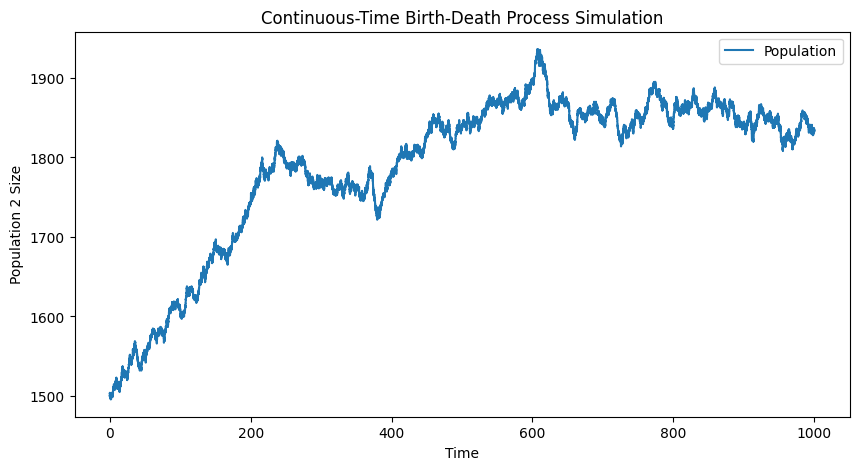

In [28]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.step(t, X2, where="post", label='Population')
plt.xlabel('Time')
plt.ylabel('Population 2 Size')
plt.title('Continuous-Time Birth-Death Process Simulation')
plt.legend()
plt.show()

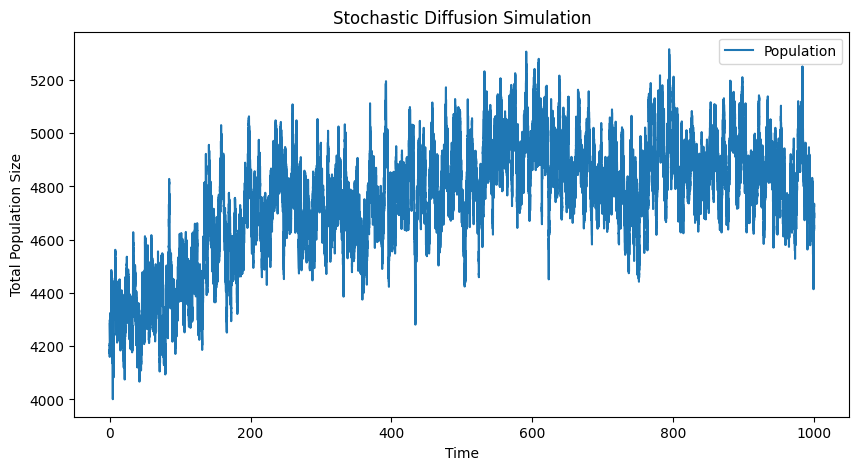

In [ ]:
# Plot the SDE results
plt.figure(figsize=(10, 5))
plt.plot(t, [X1[i] + X2[i] for i in range(len(X1))], label='Population')
plt.xlabel('Time')
plt.ylabel('Total Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation' )
plt.legend()
plt.show()

### Deterministic model

In [30]:
equilibrium = (n * lambda21 * lambda12 / death2 - death1 - lambda12)/comp
print("Equilibrium = ", equilibrium)

Equilibrium =  3070.9999999999995


In [31]:
# Define the associated ODE system
def ode(X, t, death1, comp, death2, lambda12, lambda21, n):
    X1, X2 = X
    dX1dt = n * lambda21 * X2 - (death1 + comp * X1 + lambda12) * X1
    dX2dt = lambda12 * X1 - death2 * X2
    return [dX1dt, dX2dt]

# Define the time points for the ODE solution
interval = np.linspace(0, Tmax, 100000)

# Solve the ODE system
def ode_sim(interval, X1, X2, death1, comp, death2, lambda12, lambda21, n):
    X = odeint(ode, [X1, X2], interval, args=(death1, comp, death2, lambda12, lambda21, n))
    return X[:, 0], X[:, 1]

In [32]:
# Run the ODE simulation
X1_ode, X2_ode = ode_sim(interval, Xinit[0], Xinit[1], death1, comp, death2, lambda12, lambda21, n)

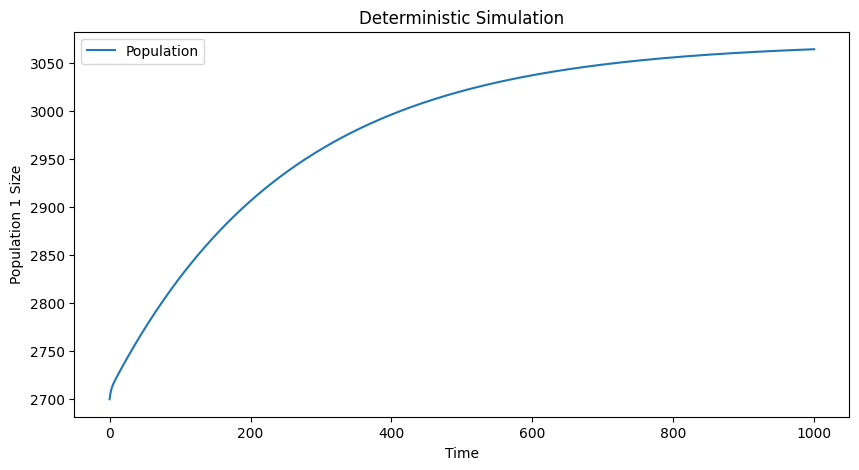

In [33]:
# Plot the ODE results
plt.figure(figsize=(10, 5))
plt.plot(interval, X1_ode, label='Population')
plt.xlabel('Time')
plt.ylabel('Population 1 Size')
plt.title('Deterministic Simulation')
plt.legend()
plt.show()

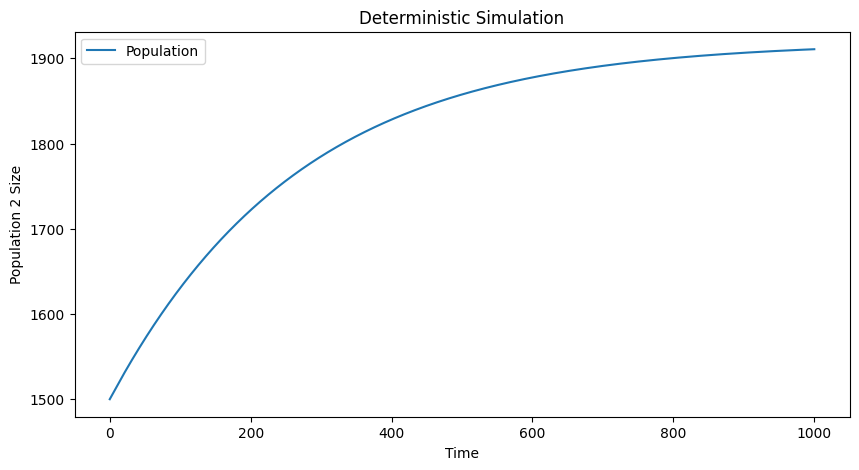

In [34]:
# Plot the ODE results
plt.figure(figsize=(10, 5))
plt.plot(interval, X2_ode, label='Population')
plt.xlabel('Time')
plt.ylabel('Population 2 Size')
plt.title('Deterministic Simulation')
plt.legend()
plt.show()

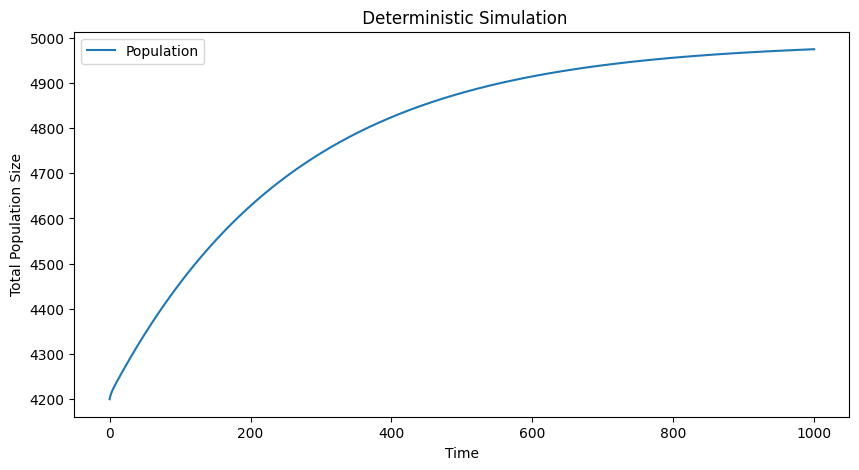

In [35]:
# Plot the SDE results
plt.figure(figsize=(10, 5))
plt.plot(interval, [X1_ode[i] + X2_ode[i] for i in range(len(X1_ode))], label='Population')
plt.xlabel('Time')
plt.ylabel('Total Population Size')
plt.title(' Deterministic Simulation')
plt.legend()
plt.show()

## Second case : slow-fast convergence

Using the generator of the new birth death process, the limit stochastic diffusion for the total population 1+2 is given by
$$dS_t = \frac{\gamma_{12}(n\lambda_{21}-\delta_2) - \gamma_2 \delta_1}{\gamma_{12}+\gamma_2}S_t dt + \sqrt{(n+1)n \frac{\gamma_{21}\gamma_{12}}{\gamma_{12} + \gamma_2} S_t} dB_t$$

In [36]:
gamma12 = 5000 * lambda12
gamma1 = 5000 * (death1 + comp)
gamma2 = 5000 * death2
gamma21 =  (gamma1 + gamma12) * gamma2 /(n * gamma12)
print("gamma21 = ", gamma21)

if (gamma12/gamma2 != (gamma1 + gamma12)/(n*gamma21)):
    print("The condition at the Kth order is not satisfied.")
    exit(1)

gamma21 =  2.2


In [37]:
# Define the stochastic diffusion using Euler- scheme
coeff_diff = n*(n+1)* gamma12 * gamma21 /(gamma12 + gamma2)
coeff_drift = (gamma12 * (n * lambda21 - death2) - gamma2 * death1) / (gamma12 + gamma2)

In [38]:
(gamma12 + gamma2)/(gamma2 )

1.625

In [39]:
coeff_drift *( gamma12 + gamma2) ** 2 / (gamma2 * gamma2 * comp) 

4990.375

In [40]:
# Define the SDE function
def sde(X, coeff_drift, coeff_diff, dt):
    dX = (coeff_drift - (gamma2 * gamma2 * comp * X / (gamma2 + gamma12)**2)) * X * dt  +  np.sqrt(coeff_diff * X) * np.random.normal(0, dt)
    return dX

def sde_sim(X0, Tmax, dt, coeff_drift, coeff_diff):
    t = np.arange(0, Tmax, dt)
    X = np.zeros(len(t))
    X[0] = X0
    for i in range(1, len(t)):
        X[i] = X[i-1] + sde(X[i-1], coeff_drift, coeff_diff, dt)
    return t, X

In [41]:
# Run the SDE simulation
dt = 0.01
X0 = Xinit[0] + Xinit[1]
t, X_sde = sde_sim(X0, Tmax, dt, coeff_drift, coeff_diff)
# Plot the SDE results

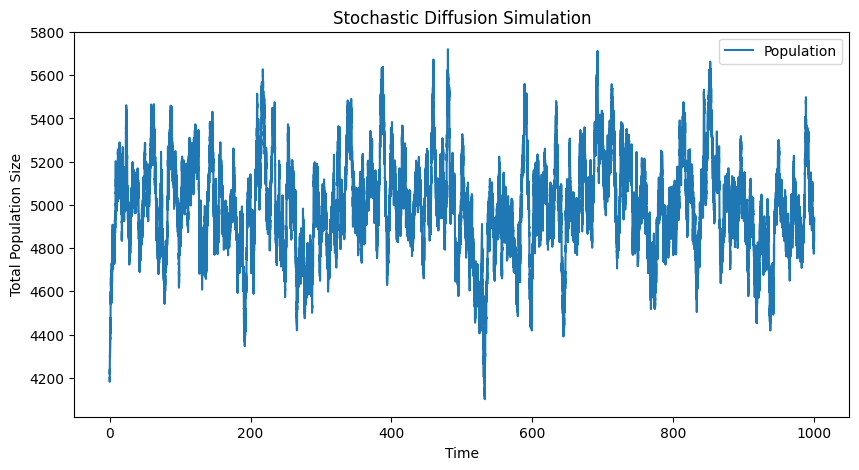

In [42]:
# Plot the SDE results
plt.figure(figsize=(10, 5))
plt.plot(interval, X_sde, label='Population')
plt.xlabel('Time')
plt.ylabel('Total Population Size')
plt.title('Stochastic Diffusion Simulation')
plt.legend()
plt.show()

In [44]:
X1_sde = gamma2 / (gamma2 + gamma12) * X_sde
X2_sde = gamma12 / (gamma2 + gamma12) * X_sde

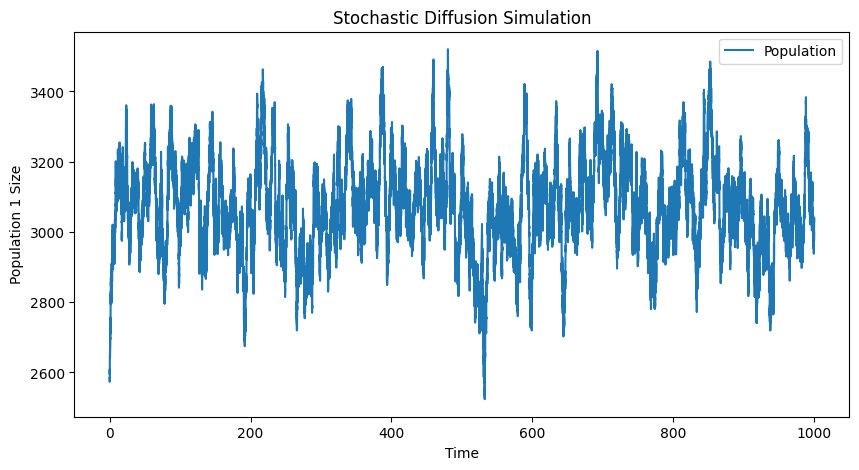

In [45]:
# Plot X1_sde
plt.figure(figsize=(10, 5))
plt.plot(interval, X1_sde, label='Population')
plt.xlabel('Time')
plt.ylabel('Population 1 Size')
plt.title('Stochastic Diffusion Simulation')
plt.legend()
plt.show()

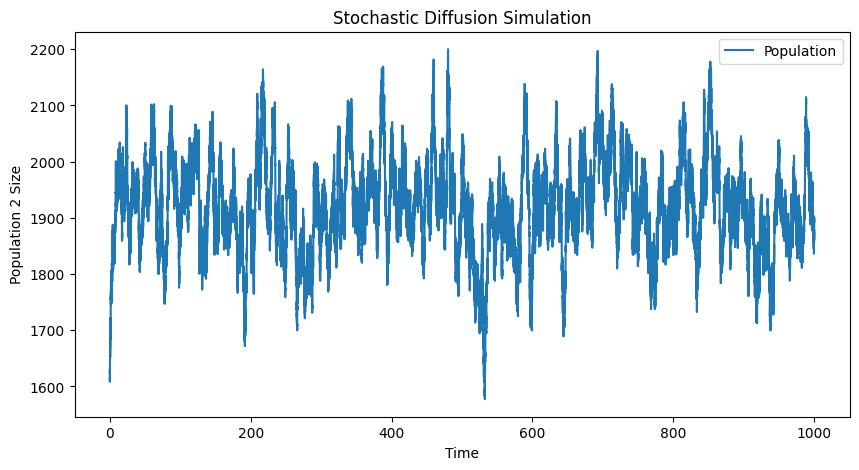

In [46]:
# Plot X2_sde
plt.figure(figsize=(10, 5))
plt.plot(interval, X2_sde, label='Population')
plt.xlabel('Time')
plt.ylabel('Population 2 Size')
plt.title('Stochastic Diffusion Simulation')
plt.legend()
plt.show()